In [1]:
# Attempting to recover training data using model's parameters and a DCGAN that was trained on similar data
# Author: Suraj Neupane
# Written from scratch as a part of a Research Project 2025, Concordia University of Edmonton.
import numpy as np

import torch
from torch import nn

from torch.utils import data
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets
from torchvision import transforms

import pickle

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
torch.__version__

'2.5.1+cu118'

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
device

'cuda'

In [5]:
# DCGAN Implementation Class
# Discriminator
class Discriminator(nn.Module):
    def __init__(self, img_channels, features_d):
        super().__init__()
        self.disc = nn.Sequential(
            # Input shape: img_channels x 64 x 64
            nn.Conv2d(
              in_channels=img_channels, out_channels=features_d, kernel_size=4, stride=2, padding=1
            ), # Output shape: features_d x 32 x 32
            nn.LeakyReLU(0.2),
            self._block(features_d, features_d*2, 4, 2, 1), # Output shape: features_d*2 x 16 x 16
            self._block(features_d*2, features_d*4, 4, 2, 1), # Output shape: features_d*4 x 8 x 8
            self._block(features_d*4, features_d*8, 4, 2, 1), # Output shape: features_d*8 x 4 x 4
           
            nn.Conv2d(in_channels=features_d*8, out_channels=1, kernel_size=4, stride=2, padding=0), # Output shape: 1 x 1
            nn.Sigmoid(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )

    def forward(self, X):
        return self.disc(X)


In [6]:
# Generator
class Generator(nn.Module):
    def __init__(self, z_dim, img_channels, features_g):
        super().__init__()
        self.gen = nn.Sequential(
            self._block(z_dim, features_g*16, 4, 1, 0), # z_dim: (batch_size, 100, 1, 1) -> (batch_size, 1024, 4, 4)
            self._block(features_g*16, features_g*8, 4, 2, 1), # z_dim: (batch_size, 1024, 4, 4) -> (batch_size, 512, 8, 8)
            self._block(features_g*8, features_g*4, 4, 2, 1), # z_dim: (batch_size, 512, 8, 8) -> (batch_size, 256, 16, 16)
            self._block(features_g*4, features_g*2, 4, 2, 1), # z_dim: (batch_size, 128, 16, 16) -> (batch_size, 64, 32, 32)
            nn.ConvTranspose2d(
                in_channels=features_g*2, out_channels=img_channels, kernel_size=4, stride=2, padding=1 # z_dim: (batch_size, 64, 32, 32) -> (batch_size, 1, 64, 64)
            ),
            nn.Tanh(),
        )
        
    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels, out_channels, kernel_size, stride, padding, bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, X):
        return self.gen(X)

In [7]:
# Hyperparams
z_dim = 100
img_channels = 1
features_disc = 64
features_gen = 64

In [8]:
# Create the model instances
gen = Generator(z_dim, img_channels, features_gen).to(device)
disc = Discriminator(img_channels, features_disc).to(device)

In [9]:
# Load the trained GAN
gen.load_state_dict(torch.load('saved models/Generator.pth', weights_only=True))
disc.load_state_dict(torch.load('saved models/Discriminator.pth', weights_only=True))

<All keys matched successfully>

In [43]:
# Generate a random fake image
noise = torch.randn(1, z_dim, 1, 1).to(device)
fake_img = gen(noise)

In [44]:
fake_img.shape

torch.Size([1, 1, 64, 64])

torch.Size([64, 64])


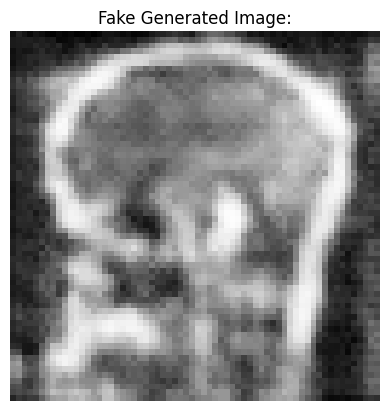

In [45]:
fake_img = fake_img.squeeze()
print(fake_img.shape)
plt.axis(False)
plt.title('Fake Generated Image:')
plt.imshow(fake_img.cpu().detach(), cmap='gray')